In [1]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
# import gym_pygame

# Hugging Face Hub
# from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

In [2]:
env_id = "gym_tetris:tetris_rl"
env = gym.make(env_id, render_mode='rgb_array')
eval_env = gym.make(env_id, render_mode='rgb_array')
s_size = env.observation_space.shape
a_size = env.action_space.n

Built Tetris v3.0
Built Tetris v3.0


/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

print(env.observation_space.shape)

_____OBSERVATION SPACE_____ 

The State Space is:  (1, 29, 10)
Sample observation [[[1.1853448e-01 1.1935332e+00 3.6651593e-01 1.0143149e+00 1.7234696e+00
   1.1936885e+00 4.4079804e-01 5.3905350e-01 1.9289915e-01 1.6910653e+00]
  [4.4803938e-01 4.1793266e-01 7.3148096e-01 1.9966519e+00 1.6043204e+00
   1.4602240e+00 1.7899201e+00 1.0009949e+00 1.5783606e+00 6.6036403e-01]
  [9.3107790e-01 1.2452197e+00 1.8072522e+00 4.5276421e-01 9.5189202e-01
   7.1891922e-01 1.9105222e+00 1.5596386e+00 2.5913483e-01 6.9949669e-01]
  [8.2426214e-01 7.8839469e-01 4.0960798e-01 1.0712421e+00 1.1887653e+00
   5.1954091e-01 1.4339533e+00 5.2838731e-01 1.4825202e+00 9.1926225e-02]
  [2.2095633e-01 1.3298913e+00 1.0314487e+00 4.3830987e-02 2.1234204e-01
   1.4876292e+00 3.3185861e-01 1.0371760e+00 6.5475899e-01 8.6550629e-01]
  [6.9062668e-01 1.3682244e+00 1.4129093e-01 6.6697639e-01 1.9663993e+00
   6.3536990e-01 5.4576176e-01 1.8976828e+00 1.6995713e+00 1.8739257e+00]
  [1.8808479e+00 6.1152142e-01 1.741

In [5]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size, h2_size):
        super(Policy, self).__init__()

        # Convolutional Network
        # self.conv = nn.Sequential(nn.Conv2d(s_size[0], h_size, 4), nn.ReLU(),
        #     nn.Conv2d(h_size, h_size, kernel_size=3, stride=1),nn.ReLU())
        # # print(self.conv(torch.zeros(1,*s_size,4)).size())
        # self.fc = nn.Sequential(
        #     nn.Linear(int(np.prod(self.conv(torch.zeros(1,*s_size)).size())), h2_size),
        #     nn.ReLU(),
        #     nn.Linear(h2_size, a_size)
        # )

        # Linear Network
        self.fc1 = nn.Linear(np.prod(s_size), h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, a_size)

        

    def forward(self, x):
        # Convlutional Network
        # x = self.conv(x).view(x.size()[0], -1)
        # x = self.fc(x)

        # Linear Network
        # x = np.reshape(x,(1,-1))
        x = np.reshape(x.swapaxes(1,2),(1,-1))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        # print(np.shape(x))
        # We output the softmax
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [6]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # best_run = []
    # best_score = 0
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # img = env.render()
        # Line 4 of pseudocode
        # images = []
        for t in range(max_t):
            action, log_prob = policy.act(state) # Code Here: get the action
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            # img = env.render()
            # images.append(img)
            rewards.append(reward)
            if done:
                break
        reward_total = sum(rewards)
        # if reward_total > best_score:
        #     best_score = reward_total
        #     best_run = images
        scores_deque.append(reward_total)
        scores.append(reward_total)

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        ## We compute this starting from the last timestep to the first, to avoid redundant computations

        ## appendleft() function of queues appends to the position 0
        ## We use deque instead of lists to reduce the time complexity

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(gamma*disc_return_t + rewards[t]) # Code Here: complete here

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    # imageio.mimsave('./best_training_run.mp4', [np.array(img) for i, img in enumerate(images)], fps=30)
    return scores

In [15]:
hyperparameters = {
    "h_size": 64,
    "h2_size": 512,
    "n_training_episodes": 20000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [8]:
# Create policy and place it to the device
torch.manual_seed(1234) # Don't change this
tetris_policy = Policy(hyperparameters["state_space"], hyperparameters["action_space"], hyperparameters["h_size"], hyperparameters["h2_size"]).to(device)
tetris_optimizer = optim.Adam(tetris_policy.parameters(), lr=hyperparameters["lr"])

In [13]:
# Loading existing policy
state = torch.load('./training_state_final_flipped.data')
tetris_optimizer.load_state_dict(state['optimizer'])
tetris_policy.load_state_dict(state['model'])

<All keys matched successfully>

In [9]:
first = True

In [16]:
if first:
    scores = []
    first = False
print(len(scores))
scores.extend(reinforce(tetris_policy,
                   tetris_optimizer,
                   hyperparameters["n_training_episodes"],
                   hyperparameters["max_t"],
                   hyperparameters["gamma"],
                   1000))

0
Episode 1000	Average Score: 1.48
Episode 2000	Average Score: 1.37
Episode 3000	Average Score: 1.47
Episode 4000	Average Score: 1.47
Episode 5000	Average Score: 1.52
Episode 6000	Average Score: 1.40
Episode 7000	Average Score: 1.52
Episode 8000	Average Score: 1.30
Episode 9000	Average Score: 1.61
Episode 10000	Average Score: 1.56
Episode 11000	Average Score: 1.56
Episode 12000	Average Score: 1.58
Episode 13000	Average Score: 0.24
Episode 14000	Average Score: 0.21
Episode 15000	Average Score: 0.19
Episode 16000	Average Score: 0.30
Episode 17000	Average Score: 0.26
Episode 18000	Average Score: 0.18
Episode 19000	Average Score: 0.27
Episode 20000	Average Score: 0.15


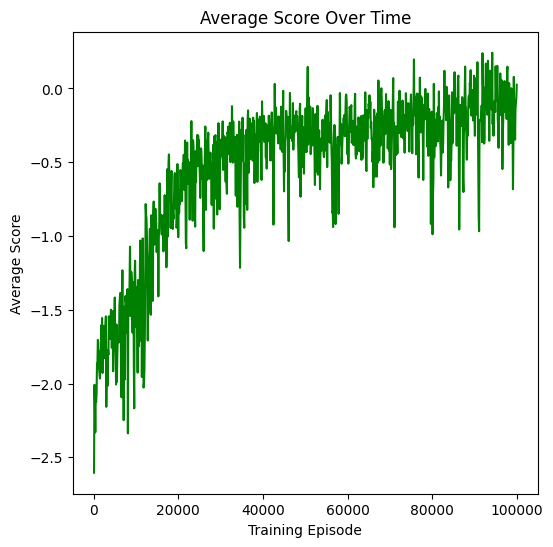

In [18]:
figure, axes = plt.subplots(1, figsize=(6, 6))

### YOUR CODE STARTS HERE ###
    
axes.set_title('Average Score Over Time')
axes.set_xlabel('Training Episode')
axes.set_ylabel('Average Score')
axes.plot(range(100,len(scores)+1,100), [np.mean(scores[100*i:100*i+100]) for i in range(len(scores)//100)], color = 'green')

In [23]:
file = open('./scores_flipped_100k.txt','w')
for item in scores:
	file.write(f'{item} ')
file.write('\n')
file.flush()
file.close()

In [19]:
# Saving current policy for continued training
from time import gmtime, strftime
curr_time = strftime("%Y.%m.%d-%H.%M.%S", gmtime())
training_state = {'model':tetris_policy.state_dict(), 'optimizer':tetris_optimizer.state_dict()}
torch.save(training_state, f'./training_state_flipped_{curr_time}.data')

In [21]:
def record_video(env, policy, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  done = False
  state = env.reset()
  img = env.render()
  images.append(img)
  for frame in range(1000):
    if done:
      break
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [22]:
from time import gmtime, strftime
curr_time = strftime("%Y.%m.%d-%H.%M.%S", gmtime())
record_video(eval_env, tetris_policy, f'./replay_flipped_{curr_time}.mp4')

/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is wri